In [652]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import curve_fit
import pandas as pd
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import interact, interactive, FloatSlider, FloatText, Button, VBox, fixed
from IPython.display import display, clear_output
import numpy as np
#from uncertainties import ufloat
#import uncertainties.unumpy as unp

In [653]:
path = 'calibration.csv'
df = pd.read_csv(path)

In [654]:
df.head()

,Time,minutes,corr_conc,recovery,std_corrconc,rec_std
0,2021-11-15 14:29:07,0,0.0,0.0,0.0,0.0
1,2021-11-15 14:31:07,2,0.0,0.0,0.0,0.0
2,2021-11-15 14:33:07,4,0.0,0.0,0.0,0.0
3,2021-11-15 14:35:07,6,0.0,0.0,0.0,0.0
4,2021-11-15 14:37:07,8,0.0,0.0,0.0,0.0


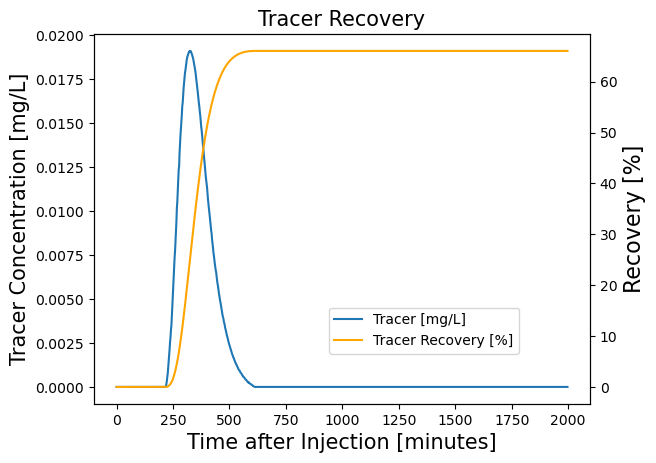

In [655]:
df = pd.read_csv('calibration.csv')

# plot df['corr_conc]
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(df['minutes'], df['corr_conc'])
ax2.plot(df['minutes'], df['recovery'], color = 'orange')

ax.set_title("Tracer Recovery", fontsize=15)

ax.set_ylabel("Tracer Concentration [mg/L]", fontsize=(15))
ax.set_xlabel("Time after Injection [minutes]", fontsize=(15))
ax2.set_ylabel("Recovery [%]", fontsize=16)

fig.legend(['Tracer [mg/L]', 'Tracer Recovery [%]'], loc = 'lower right', bbox_to_anchor=(0.8, 0.2))



In [659]:
class OneDimensionalAdvectionDispersionModel:
    def __init__(self, real_data_file, x=300, m_in=2.05, Q=11e-3):
        self.real_data = pd.read_csv(real_data_file)
        self.real_data['seconds'] = self.real_data['minutes'] * 60  # Convert minutes to seconds
        self.x = x  # Distance (m)
        self.m_in = m_in  # Mass input rate (g)
        self.Q = Q  # Flow rate (m^3/s)
        self.popt = None  # Optimal parameters after fitting
        self.pcov = None  # Covariance of popt
        self.fitted_line = None  # Placeholder for the fitted line
        self.model_line = None  # Placeholder for the model line

    def return_real_data(self):
        return self.real_data
    
    def return_manual_adjusted_model(self):
        return self.manual_model_line

    def return_fitted_model(self):
        return self.auto_model_line

    def diff_fit(self, t, D, v, Q=None, m_in=None, x=None):

        if Q is None:
            Q = self.Q
        if m_in is None:
            m_in = self.m_in
        if x is None:
            x = self.x

        term1 = m_in / Q
        term2 = x / (np.sqrt(4 * np.pi * D * t**3) + 1e-10)
        return term1 * term2 * np.exp(-((x - v * t)**2) / ((4 * D * t) + 1e-10))

    def initial_plot(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        self.fig = fig
        self.ax = ax
        ax.plot(self.real_data['seconds'], self.real_data['corr_conc'], label='Real Data (Concentration)', color='orange')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Concentration')
        ax.set_title('Concentration vs. Time')
        plt.legend()
        #plt.show()
        plt.close()

        self.fixed_x_range = (self.real_data['seconds'].min(), self.real_data['seconds'].max()*1.2)
        self.fixed_y_range = (self.real_data['corr_conc'].min(), self.real_data['corr_conc'].max()*1.2)

    def fit_model(self, p0, bounds):
        try:
            t = self.real_data['seconds'].values
            conc = self.real_data['corr_conc'].values
            self.popt, self.pcov = curve_fit(self.diff_fit, t, conc, p0=eval(p0), bounds=eval(bounds))
            print(f"Fitted parameters: D = {self.popt[0]:.3f}, v = {self.popt[1]:.3f}")
        except Exception as e:
            print(f"An error occurred during fitting: {e}")

    def plot_with_model(self, D, v, Q, m_in, x):
        clear_output(wait=True)
        self.ax.clear()  # Clear the existing plot
        plt.close()

        seconds = self.real_data['seconds'].values
        t_values = np.linspace(seconds.min(), seconds.max(), 1000)
        #t_values = np.linspace(self.fixed_x_range[0], self.fixed_x_range[1], 1000)
        c_values = self.diff_fit(t_values, D, v, Q, m_in, x)

        self.ax.plot(self.real_data['seconds'], self.real_data['corr_conc'], label='Data (Concentration)', color='orange')
        self.ax.plot(t_values, c_values, label=f"Manuel Fit (D: {D:.3f}, v: {v:.3f})", color='blue')

        if self.popt is not None:
            fitted_values = self.diff_fit(t_values, *self.popt)
            self.ax.plot(t_values, fitted_values, label=f"Automatic Fit (D: {self.popt[0]:.3f}, v: {self.popt[1]:.3f})", color='red')
            self.auto_model_line = fitted_values
            
        self.ax.set_xlim(self.fixed_x_range)
        self.ax.set_ylim(self.fixed_y_range)
        self.ax.set_xlabel('Time (seconds)')
        self.ax.set_ylabel('Concentration')
        self.ax.set_title('1D Advection Dispersion Model')
        self.ax.legend()
        
        display(self.fig)  # Display the figure

        self.manual_model_line = c_values
        self.t_values = t_values
        

    def create_interactive_plot(self):
        # Slider widgets
        D_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.0005, description='Diffusion Coefficient (D):', readout_format='.3f')
        v_slider = widgets.FloatSlider(value=1, min=0, max=0.09, step=0.00005, description='Velocity (v):', readout_format='.3f')
        Q_slider = FloatSlider(value=self.Q, min=0.001, max=0.02, step=0.001, description='Flow rate (Q):', readout_format='.4f')
        m_in_slider = FloatSlider(value=self.m_in, min=1, max=3, step=0.05, description='Mass input rate (m_in):', readout_format='.2f')
        x_slider = FloatSlider(value=self.x, min=100, max=1500, step=10, description='Distance (x):', readout_format='.0f')
        
        # Text input widgets for adjusting the x-axis range
        xmin_text = FloatText(value=self.fixed_x_range[0], description='Xmin:')
        xmax_text = FloatText(value=self.fixed_x_range[1], description='Xmax:')

        p0_text = widgets.Text(value="(0.1, 1)", description="Initial Guess (p0):")
        bounds_text = widgets.Text(value="(0, [np.inf, np.inf])", description="Bounds:")
        fit_button = Button(description="Fit Model")

        # Function to update the plot with the new model parameters and x-axis range
        def update_plot(D, v, Q, m_in, x, xmin, xmax):
            self.fixed_x_range = (xmin, xmax)
            self.plot_with_model(D, v, Q, m_in, x)

        # Function to handle fitting the model when the button is clicked
        def on_fit_button_clicked(b):
            self.fit_model(p0_text.value, bounds_text.value)
            update_plot(D_slider.value, v_slider.value, Q_slider.value, m_in_slider.value, x_slider.value, xmin_text.value, xmax_text.value)

        fit_button.on_click(on_fit_button_clicked)

        # Create the interactive plot with the new parameters
        interactive_plot = interactive(update_plot, 
                                       D=D_slider, 
                                       v=v_slider, 
                                       Q=Q_slider, 
                                       m_in=m_in_slider, 
                                       x=x_slider, 
                                       xmin=xmin_text, 
                                       xmax=xmax_text)

        # Display the widgets and the interactive plot
        display(VBox([p0_text, bounds_text, fit_button, interactive_plot]))


# Usage

In [660]:
path_to_data = 'calibration.csv'

# Parameter Eingabe (kann nachher noch geändert werden)
distance = 300  # m
mass_input_rate = 2.05  # g
flow_rate = 11e-3  # m^3/s

model = OneDimensionalAdvectionDispersionModel(path_to_data, x=distance, m_in=mass_input_rate, Q=flow_rate)
model.initial_plot()
model.create_interactive_plot()

Direkt nachdem man auf den fit_model button geclickt hat ist der plot nicht mehr interaktiv. Anschließend kann man die nächsten Zellen laufen lassen undsich ansehen wie gut der 
manuelle fit im vergleich zu dem automatischen fit ist. Die automatische Fitting methode benötigt jedenfalls einen initial guess der nicht zu weit vom wahren wert entfernt ist damit das ganze halbwegs gut funktioniert. 

In [658]:
manual_adjusted_model = model.return_manual_adjusted_model()
fitted_model = model.return_fitted_model()
real_data= model.return_real_data()

AttributeError: 'OneDimensionalAdvectionDispersionModel' object has no attribute 'auto_model_line'

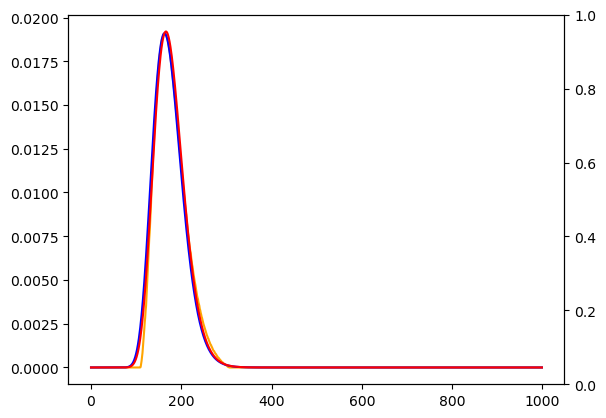

In [ ]:
# plot 
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(real_data['corr_conc'], color ='orange')
ax.plot(manual_adjusted_model, color = 'blue')
ax.plot(fitted_model, color = 'red')

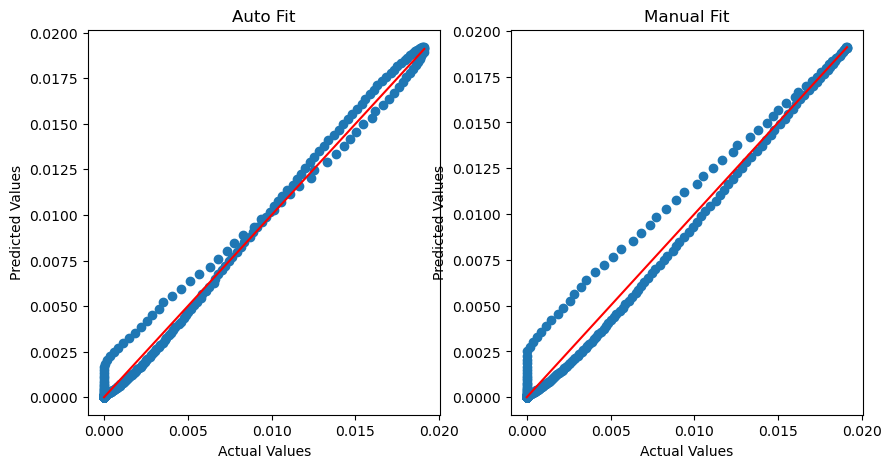

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have two lists: y_actual and y_predicted for both auto and manual fit
y_actual = real_data['corr_conc']
y_predicted_auto = fitted_model
y_predicted_manual = manual_adjusted_model

plt.figure(figsize=(10, 5))

# Plot for auto fit
plt.subplot(1, 2, 1)
plt.scatter(y_actual, y_predicted_auto)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Auto Fit')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red') # 45 degree line

# Plot for manual fit
plt.subplot(1, 2, 2)
plt.scatter(y_actual, y_predicted_manual)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Manual Fit')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red') # 45 degree line

plt.show()

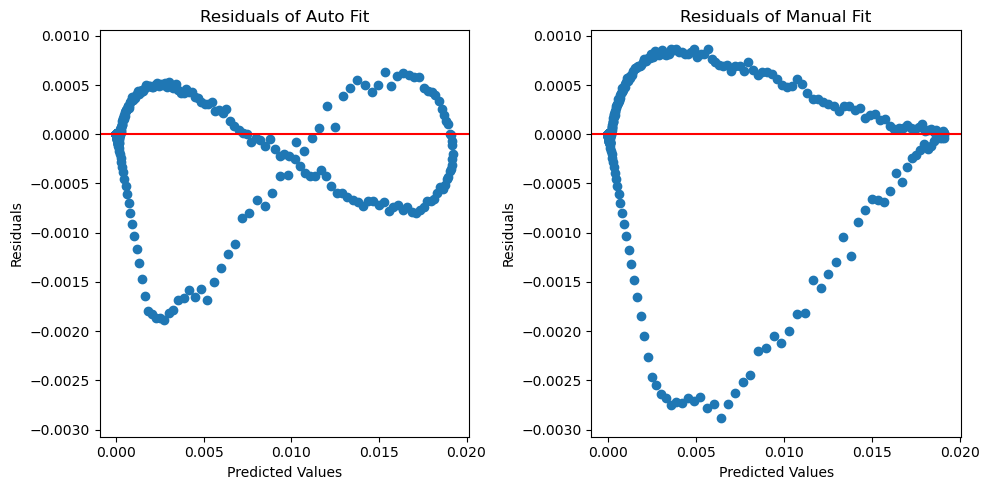

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals for auto and manual fit
residuals_auto = [actual - predicted for actual, predicted in zip(y_actual, y_predicted_auto)]
residuals_manual = [actual - predicted for actual, predicted in zip(y_actual, y_predicted_manual)]

plt.figure(figsize=(10, 5))

# Residual plot for auto fit
plt.subplot(1, 2, 1)
plt.scatter(y_predicted_auto, residuals_auto)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals of Auto Fit')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Residual plot for manual fit
plt.subplot(1, 2, 2, sharey=plt.gca())
plt.scatter(y_predicted_manual, residuals_manual)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals of Manual Fit')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()